# 자율주행 센서의 안테나 성능 예측 AI 경진대회

- Name    :  Jeonghyeon Kim (Henney Kim)
- E-mail  :  zmsdkdle@khu.ac.kr, kjh3765@hotmail.com

In [119]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans

In [120]:
train = pd.read_csv('./train.csv')

## EDA & Data Preprocessing

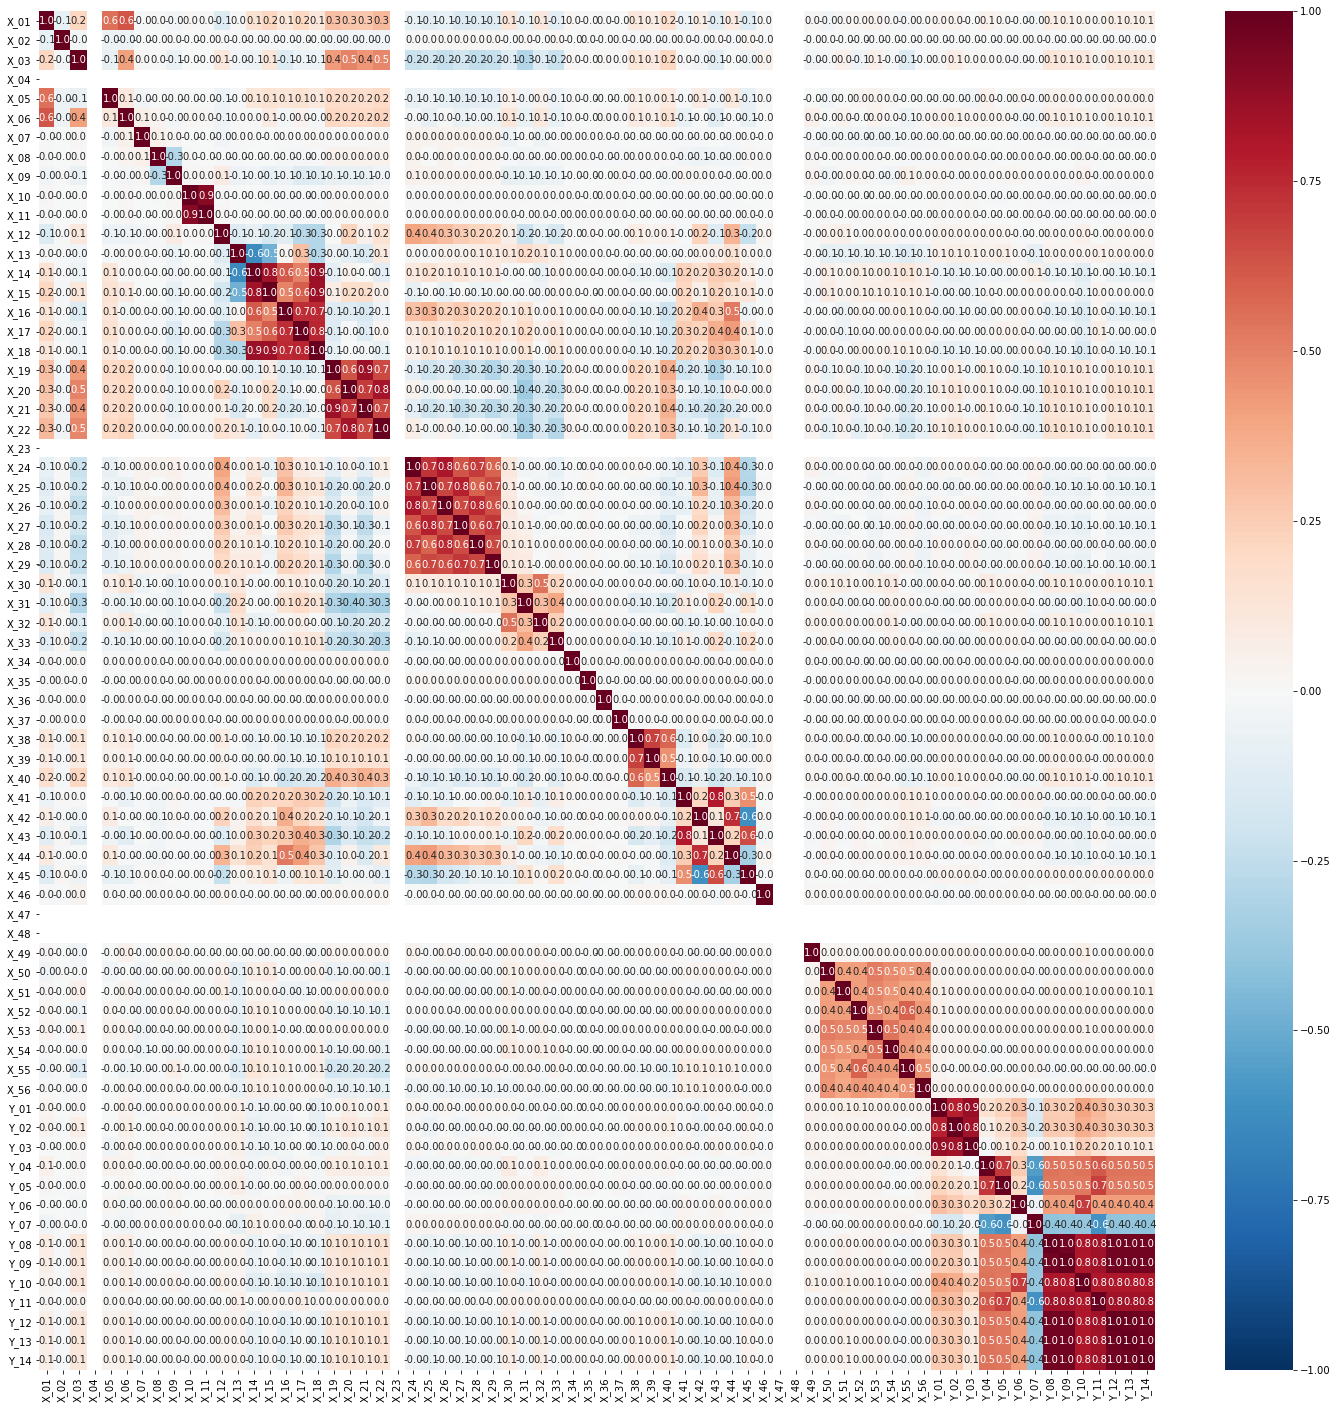

In [3]:
# 상관관계 확인
plt.figure(figsize=(25, 25))
sns.heatmap(train.iloc[:, 1:].corr(), cmap='RdBu_r', vmax=1, vmin=-1, annot=True, fmt='.1f')
plt.show()

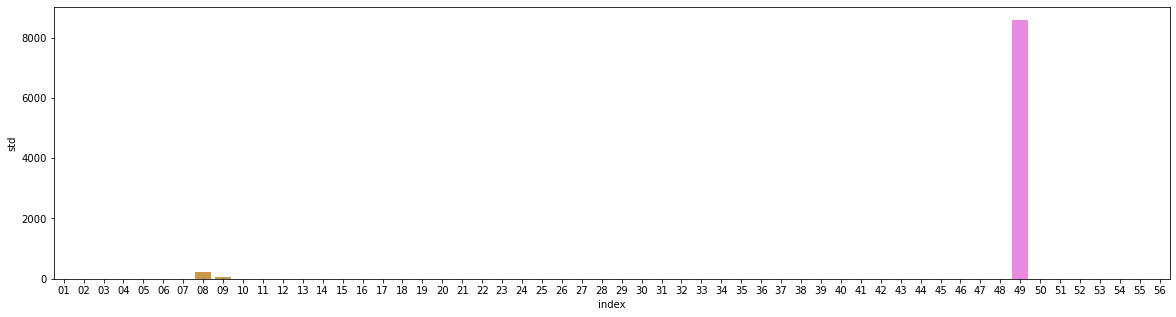

In [123]:
# 특성의 편차를 시각화
plt.figure(figsize=(20, 5))
data_std = pd.DataFrame(train_x.describe().iloc[2, :])
data_std = data_std.reset_index()
data_std.replace('X_', '', regex=True, inplace=True)
sns.barplot(x = 'index', y='std', data=data_std)
plt.show()

# X_49(Cal 투입 전 대기 시간)의 경우 편차가 매우 큼

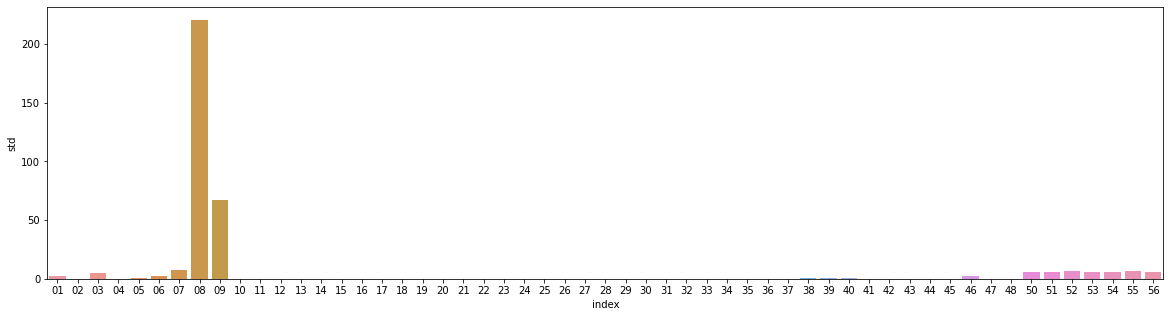

In [124]:
# 49번째 특성을 제외하고 시각화
plt.figure(figsize=(20, 5))
sns.barplot(x = 'index', y='std', data=data_std.drop(data_std.index[48]))
plt.show()

# 값이 매우큰 X_49를 제외했을 때, 그 다음으로 X_8과 X_9가 편차가 큰 것을 확인할 수 있음

In [109]:
print(train.loc[:, ['X_07', 'X_08', 'X_09', 'X_03', 'X_10', 'X_11']].head(), '\n')

print('X_10 특성 0의 개수:', sum(train.X_10 == 0))
print('X_11 특성 0의 개수:', sum(train.X_11 == 0))

# 방열 재료 2, 3의 경우 면적은 있지만 무게가 0인 데이터가 많음 --> X_10, X_11 제거

    X_07    X_08    X_09   X_03  X_10  X_11
0  29.45   62.38  245.71  67.47   0.0   0.0
1  28.73   61.23  233.61  65.17   0.0   0.0
2  28.81  105.77  272.20  64.07   0.0   0.0
3  28.92  115.21  255.36  67.57   0.0   0.0
4  29.68  103.38  241.46  63.57   0.0   0.0 

X_10 특성 0의 개수: 39575
X_11 특성 0의 개수: 39580


In [110]:
print('X_04 값: ', train.X_04.unique())
print('X_23 값: ', train.X_23.unique())
print('X_47 값: ', train.X_47.unique())
print('X_48 값: ', train.X_48.unique())
# 1~4차 검사 통과 여부는 모두 1 --> 제거

X_04 값:  [1]
X_23 값:  [1]
X_47 값:  [1]
X_48 값:  [1]


In [121]:
# X_04, X_10, X_11, X_23, X_47, X_48 제거
train.drop(['X_04', 'X_10', 'X_11', 'X_23', 'X_47', 'X_48'], axis=1, inplace=True)

# X_04 X_23, X_47, X_48 제거
# train.drop(['X_04', 'X_23', 'X_47', 'X_48'], axis=1, inplace=True)

### Normalization

In [152]:
train_x = train.filter(regex='X')
train_y = train.filter(regex='Y')
x_colname = train_x.columns

In [153]:
scaler = MinMaxScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
train_x = pd.DataFrame(train_x, columns=x_colname)
train_x

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_12,X_13,...,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,0.500000,0.0,0.336391,0.085137,0.520025,0.102258,0.010183,0.346935,0.318182,0.565217,...,0.690476,0.500000,0.057221,0.818378,0.657283,0.829713,0.861965,0.678313,0.772826,0.774036
1,0.464276,1.0,0.266055,0.122655,0.440003,0.097449,0.009694,0.326766,0.500000,0.565217,...,0.309524,0.500000,0.063671,0.794895,0.660879,0.843594,0.780464,0.693197,0.817679,0.772908
2,0.571414,0.0,0.232416,0.994949,0.440003,0.097983,0.028655,0.391092,0.409091,0.434783,...,0.333333,0.916667,0.068392,0.788280,0.632348,0.822906,0.820963,0.687465,0.797791,0.753194
3,0.535689,0.0,0.339450,0.142136,0.600008,0.098718,0.032674,0.363021,0.272727,0.695652,...,0.523810,1.000000,0.104882,0.797750,0.645002,0.775716,0.846305,0.711607,0.846910,0.847593
4,0.464276,0.0,0.217125,0.149351,0.360020,0.103794,0.027638,0.339851,0.363636,0.478261,...,0.523810,1.000000,0.069314,0.858752,0.664588,0.743346,0.865374,0.678588,0.790558,0.760922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,0.357138,0.0,0.177370,0.992785,0.200016,0.107267,0.016760,0.434182,0.409091,0.434783,...,0.261905,1.000000,0.515087,0.768116,0.630910,0.734221,0.792995,0.653432,0.752841,0.803928
39603,0.357138,1.0,0.192661,0.178211,0.200016,0.100655,0.027156,0.388542,0.590909,0.347826,...,0.285714,0.083333,0.516280,0.751557,0.569218,0.795323,0.771575,0.661280,0.816103,0.757476
39604,0.428551,0.0,0.250765,0.988456,0.279998,0.105664,0.027310,0.267523,0.500000,0.391304,...,0.309524,0.166667,0.049194,0.786122,0.666170,0.740457,0.822309,0.712888,0.798427,0.730249
39605,0.357138,0.0,0.220183,0.181097,0.240027,0.107935,0.031563,0.396626,0.272727,0.478261,...,0.261905,1.000000,0.529397,0.755504,0.576965,0.786145,0.830138,0.677749,0.772026,0.770283


### Create Derived Variable

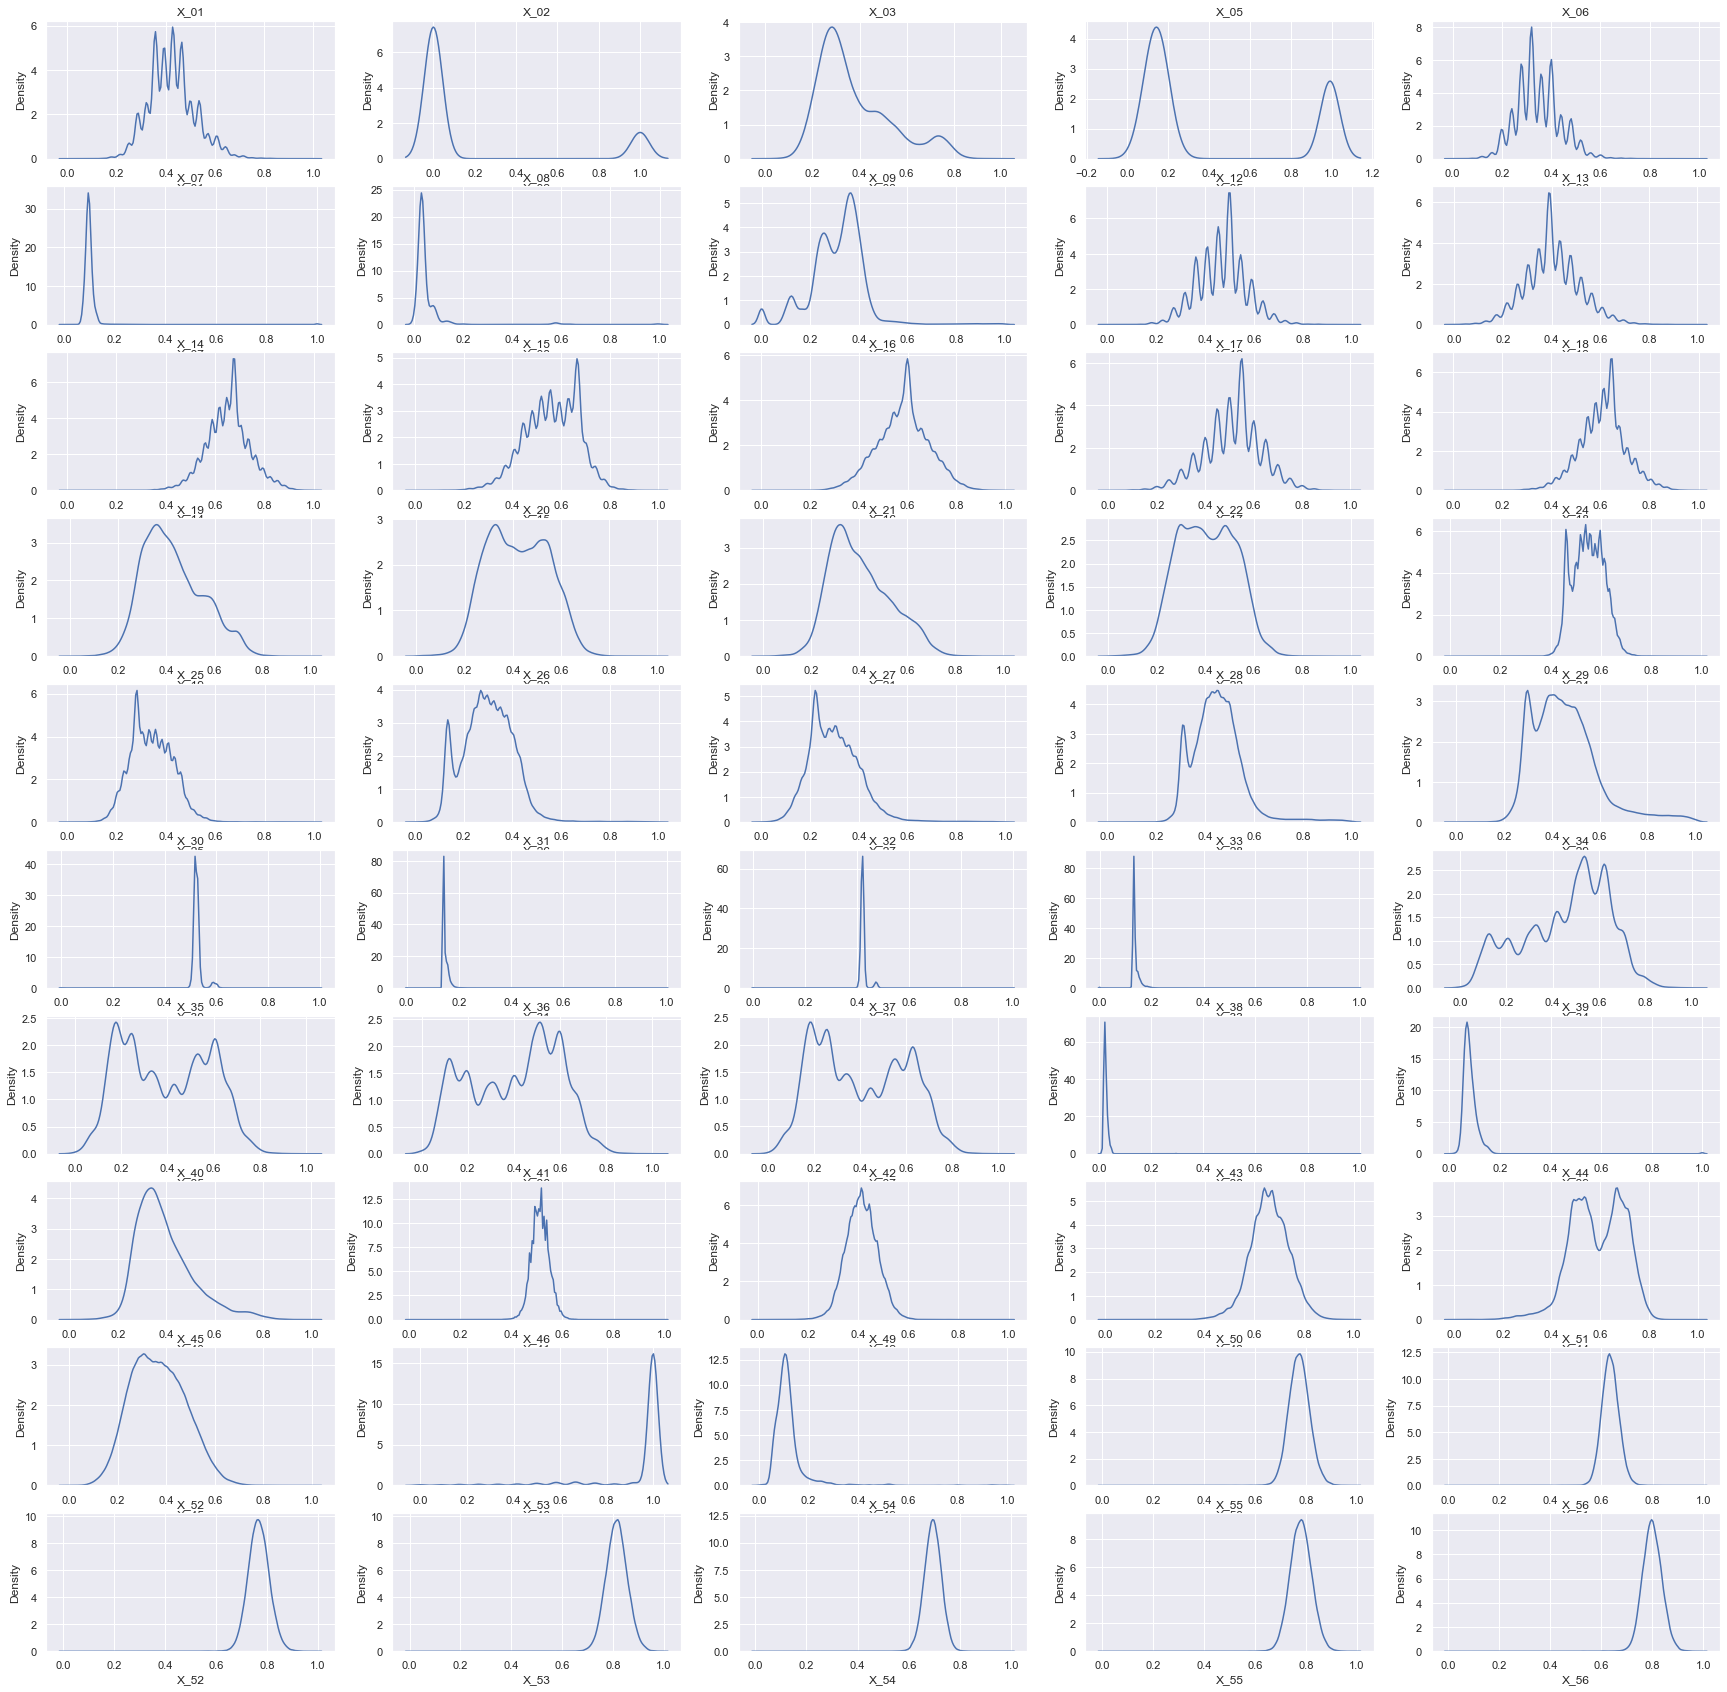

In [177]:
# 특성 별 히스토그램
fig, axes = plt.subplots(10, 5, figsize=(30, 30))

for i in range(0, 50):
    sns.kdeplot(data=train_x, x=train_x.columns[i], ax = axes[int((i)/5), (i)%5]).set_title(train_x.columns[i])

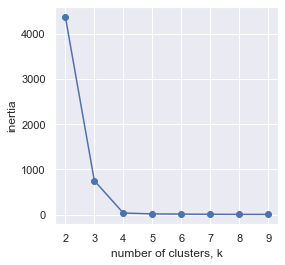

In [270]:
# kmeans으로 feature clustering

# cluster 1 (X_02, X_05)
# 적절 군집수 확인
n_num = range(2, 10)
inertias = []
for n in n_num:
    kmeans = KMeans(n_clusters=n).fit(train_x.loc[:, ["X_02", "X_05"]])
    inertias.append(kmeans.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(n_num, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(n_num)
plt.show()

In [355]:
kmeans = KMeans(n_clusters=3).fit(train_x.loc[:, ["X_02", "X_05"]])
clusters = kmeans.predict(train_x.loc[:, ["X_02", "X_05"]])
train_x['X_57'] = clusters
train_x['X_57'] = train_x['X_57'].astype('str')

ohe = OneHotEncoder(sparse=False)
dummies = ohe.fit_transform(train_x[['X_57']])

train_x.drop(['X_57'], axis=1, inplace=True)

train_x['X_57'] = dummies[:, 0]
train_x['X_58'] = dummies[:, 1]
train_x['X_59'] = dummies[:, 2]

### 불량 여부 반영

In [114]:
# train['X_57'] = 0
# train.head()

In [115]:
# defect_value = pd.read_csv('./meta/y_feature_spec_info.csv')
# defect_value.head()

In [116]:
# for i in range(0, len(defect_value)):
#     feature = defect_value.iloc[i, 0]
#     minimum = defect_value.iloc[i, 1]
#     maximum = defect_value.iloc[i, 2]

#     train.loc[((train[feature] > maximum) | (train[feature] < minimum)), "X_57"] = 1
    
# train.head(10)

In [117]:
# # 불량 여부에 따른 train data 분포 확인
# fig, axes = plt.subplots(13, 4, figsize=(30, 30))

# for i in range(1, 53):
#     sns.kdeplot(data=train, x=train.columns[i], hue="X_57", ax = axes[int((i-1)/4), (i-1)%4])

## Modeling

In [233]:
# test 데이터 로드 및 특성 제거
test_x = pd.read_csv('./test.csv').drop(columns=['ID'])
test_x.drop(['X_04', 'X_23', 'X_10', 'X_11', 'X_47', 'X_48'], axis=1, inplace=True)

# 정규화
test_x[:] = scaler.transform(test_x[:])
test_x

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_12,X_13,...,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,0.428551,1.0,0.617737,0.067100,0.480014,0.109337,0.010690,0.337084,0.454545,0.434783,...,0.380952,1.000000,0.124848,0.826096,0.623109,0.787599,0.855204,0.705025,0.748479,0.750366
1,0.392862,0.0,0.394495,0.157287,0.240027,0.092773,0.033432,0.252788,0.409091,0.521739,...,0.642857,0.416667,0.124011,0.812024,0.616190,0.816901,0.838185,0.722591,0.751814,0.767689
2,0.464276,0.0,0.382263,0.079365,0.600008,0.103593,0.071188,0.295628,0.727273,0.652174,...,0.333333,1.000000,0.103568,0.700524,0.568233,0.725029,0.756200,0.707239,0.715286,0.695207
3,0.464276,0.0,0.287462,0.066378,0.480014,0.093575,0.027638,0.238736,0.545455,0.565217,...,0.309524,1.000000,0.107090,0.796727,0.597667,0.827516,0.776741,0.680643,0.792837,0.785696
4,0.607138,1.0,0.311927,0.084416,0.520025,0.105397,0.013938,0.323965,0.500000,0.304348,...,0.214286,1.000000,0.066627,0.824589,0.655875,0.768269,0.807490,0.754086,0.757130,0.766504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,0.428551,0.0,0.229358,0.997835,0.279998,0.102525,0.033159,0.411028,0.363636,0.391304,...,0.261905,1.000000,0.528509,0.752320,0.605923,0.771724,0.792980,0.695742,0.796305,0.798422
39604,0.428551,0.0,0.149847,0.983405,0.279998,0.121226,0.033129,0.391442,0.318182,0.478261,...,0.452381,1.000000,0.525997,0.752505,0.591836,0.765862,0.751846,0.689484,0.776839,0.822908
39605,0.464276,0.0,0.220183,0.992063,0.320009,0.105931,0.031754,0.429998,0.500000,0.478261,...,0.285714,1.000000,0.511911,0.758373,0.595957,0.768662,0.783279,0.681371,0.765588,0.793778
39606,0.392862,1.0,0.162080,0.991342,0.240027,0.119623,0.032606,0.382857,0.454545,0.478261,...,0.261905,1.000000,0.511544,0.705234,0.599999,0.744253,0.759552,0.702328,0.745325,0.825240


In [359]:
# kmeans로 test feature clustering
clusters = kmeans.predict(test_x.loc[:, ["X_02", "X_05"]])
test_x['X_57'] = clusters
test_x['X_57'] = test_x['X_57'].astype('str')

ohe = OneHotEncoder(sparse=False)
dummies = ohe.fit_transform(test_x[['X_57']])

test_x.drop(['X_57'], axis=1, inplace=True)

test_x['X_57'] = dummies[:, 0]
test_x['X_58'] = dummies[:, 1]
test_x['X_59'] = dummies[:, 2]

In [361]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [362]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(units = 16, activation='relu', input_dim=train_x.shape[1]))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 256, activation='relu'))
model.add(Dense(units = train_y.shape[1]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                864       
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 14)                3598      
                                                                 
Total params: 48,462
Trainable params: 48,462
Non-trai

In [363]:
model.compile(loss = 'mse', optimizer='adam')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

In [364]:
history = model.fit(train_x, train_y,
                    epochs=50, validation_data=(val_x, val_y),
                    callbacks=[earlystopping], batch_size=32)

Epoch 1/50
793/793 [==============================] - 4s 5ms/step - loss: 15.3691 - val_loss: 2.0092
Epoch 2/50
793/793 [==============================] - 4s 5ms/step - loss: 1.7844 - val_loss: 1.7895
Epoch 3/50
793/793 [==============================] - 4s 5ms/step - loss: 1.6789 - val_loss: 1.8811
Epoch 4/50
793/793 [==============================] - 5s 6ms/step - loss: 1.6524 - val_loss: 1.7019
Epoch 5/50
793/793 [==============================] - 5s 6ms/step - loss: 1.6211 - val_loss: 1.8049
Epoch 6/50
793/793 [==============================] - 5s 6ms/step - loss: 1.6000 - val_loss: 1.6713
Epoch 7/50
793/793 [==============================] - 4s 5ms/step - loss: 1.5920 - val_loss: 1.7062
Epoch 8/50
793/793 [==============================] - 5s 6ms/step - loss: 1.5853 - val_loss: 1.7201
Epoch 9/50
793/793 [==============================] - 5s 6ms/step - loss: 1.5788 - val_loss: 1.6597
Epoch 10/50
793/793 [==============================] - 5s 6ms/step - loss: 1.5683 - val_loss: 1.710

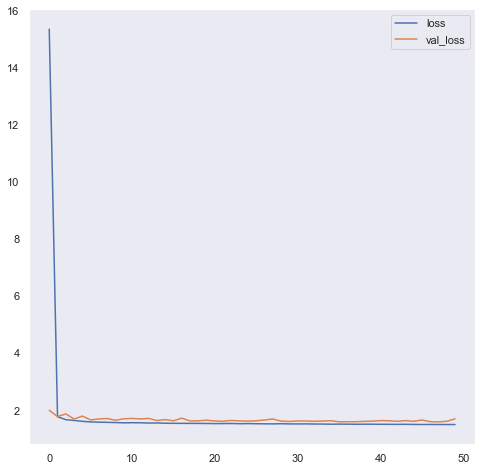

In [367]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = np.arange(len(loss))

plt.figure(figsize=(8, 8))
sns.lineplot(x=epoch, y=loss)
sns.lineplot(x=epoch, y=val_loss)
plt.legend(loc='upper right', labels=['loss', 'val_loss'])
plt.grid()
plt.show()

## Inference

In [368]:
pred = model.predict(test_x)

In [369]:
submit = pd.read_csv('./sample_submission.csv')

for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = pred[:,idx-1]
print('Done.')

Done.


In [370]:
submit.to_csv('./submit.csv', index=False)

## Memo

- 파생변수(Categorycal feature) 생성을 통한 개선
- 모델 앙상블
- 모델 구조 개선